In [1]:
import numpy as np
import pandas as pd
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [2]:
dataset = pd.read_csv('./class_7_wine_dataset_v2.csv')

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            6497 non-null   int64  
 1   type                  6497 non-null   object 
 2   fixed acidity         6487 non-null   float64
 3   volatile acidity      6489 non-null   float64
 4   citric acid           6494 non-null   float64
 5   residual sugar        6495 non-null   float64
 6   chlorides             6495 non-null   float64
 7   free sulfur dioxide   6497 non-null   float64
 8   total sulfur dioxide  6497 non-null   float64
 9   density               6497 non-null   float64
 10  pH                    6488 non-null   float64
 11  sulphates             6493 non-null   float64
 12  alcohol               6497 non-null   float64
 13  quality               6497 non-null   int64  
 14  vendor_id             6497 non-null   int64  
dtypes: float64(11), int64

In [4]:
ds = dataset[dataset.isna().sum(axis=1) == 0]
print(ds.shape)

(6463, 15)


In [5]:
y = pd.get_dummies(ds.type, prefix="type")
y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6463 entries, 0 to 6496
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   type_red    6463 non-null   uint8
 1   type_white  6463 non-null   uint8
dtypes: uint8(2)
memory usage: 63.1 KB


In [6]:
# Concatenar las dummies al dataset principal
ds = pd.concat([ds, y], axis=1)
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6463 entries, 0 to 6496
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            6463 non-null   int64  
 1   type                  6463 non-null   object 
 2   fixed acidity         6463 non-null   float64
 3   volatile acidity      6463 non-null   float64
 4   citric acid           6463 non-null   float64
 5   residual sugar        6463 non-null   float64
 6   chlorides             6463 non-null   float64
 7   free sulfur dioxide   6463 non-null   float64
 8   total sulfur dioxide  6463 non-null   float64
 9   density               6463 non-null   float64
 10  pH                    6463 non-null   float64
 11  sulphates             6463 non-null   float64
 12  alcohol               6463 non-null   float64
 13  quality               6463 non-null   int64  
 14  vendor_id             6463 non-null   int64  
 15  type_red             

In [7]:
ds.groupby('quality').count()

,Unnamed: 0,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,vendor_id,type_red,type_white
quality,,,,,,,,,,,,,,,,
3,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30
4,214,214,214,214,214,214,214,214,214,214,214,214,214,214,214,214
5,2128,2128,2128,2128,2128,2128,2128,2128,2128,2128,2128,2128,2128,2128,2128,2128
6,2820,2820,2820,2820,2820,2820,2820,2820,2820,2820,2820,2820,2820,2820,2820,2820
7,1074,1074,1074,1074,1074,1074,1074,1074,1074,1074,1074,1074,1074,1074,1074,1074
8,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192,192
9,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5


In [8]:
vendor_id = ds['vendor_id']
x_df = ds.drop(['Unnamed: 0', 'quality', 'vendor_id', 'type'], axis=1, inplace=False).to_numpy()
y_df = ds.quality.to_numpy()

In [9]:
# Output coding
index_to_quality, y_indices, y_inverse = np.unique(y_df, return_index=True, return_inverse=True)
quality_to_index = {key:value for key,value in zip(y_df,y_inverse)}
quality_index = [quality_to_index[id] for id in y_df]
quality_index = np.array(quality_index)

In [10]:
# Vendor coding
index_to_vendor, vendor_indices, vendor_inverse = np.unique(vendor_id, return_index=True, return_inverse=True)
vendor_to_index = {key:value for key,value in zip(vendor_id,vendor_inverse)}
vendor_index = [vendor_to_index[id] for id in vendor_id]
vendor_index = np.array(vendor_index)

In [11]:
#Dataset Split
x_train, x_test, Y_train, Y_test, vendor_train, vendor_test = \
    model_selection.train_test_split( x_df, quality_index, vendor_index, test_size=0.2, random_state=5,stratify=quality_index)
        
x_train, x_valid, Y_train, Y_valid, vendor_train, vendor_valid= \
    model_selection.train_test_split( x_train, Y_train, vendor_train, test_size=0.2, random_state=5, stratify=Y_train)

In [12]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure()
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    


class CustomDataset(Dataset):
    def __init__(self, X, Y):
      self.X=X
      self.Y=Y
    
    def __len__(self):
      return self.X.shape[0]
    
    def __getitem__(self, idx):
      return self.X[idx,:], self.Y[idx]
  

class TestCustomDataset(Dataset):
    def __init__(self, X):
      self.X=X
    
    def __len__(self):
      return self.X.shape[0]
    
    def __getitem__(self, idx):
      return self.X[idx,:]


class NNetLayers(torch.nn.Module):
    def __init__(self, inputs, outputs):
        super().__init__()
        self.linear_1 = torch.nn.Linear(in_features=inputs, out_features=200, bias = True)
        self.activation_1 = torch.nn.ReLU()
        self.dropout_1= torch.nn.Dropout(p=0.05)
        self.linear_2 = torch.nn.Linear(in_features=200, out_features=100, bias = True)
        self.activation_2 = torch.nn.ReLU()
        self.dropout_2= torch.nn.Dropout(p=0.05)
        self.linear_3 = torch.nn.Linear(in_features=100, out_features=outputs, bias = True)

    def forward(self, x):
        # X es el batch que va a entrar
        z1 = self.linear_1(x)
        a1 = self.activation_1(z1)
        d1 = self.dropout_1(a1)
        z2 = self.linear_2(d1)
        a2 = self.activation_2(z2)
        d2 = self.dropout_2(a2)
        y = self.linear_3(d2)     
        return y
  
    
class NnetMultiClass():
    
    def __init__(self, inputs, outputs):
        self.nnet = NNetLayers(inputs, outputs)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        pass
    
        
    def fit(self,x_train, y_train, x_valid=None, y_valid=None, \
            batch_size = 128, lr=0.001, epochs=1000, verbose=True):
        
        
        self.y_encoder = OneHotEncoder(sparse=True)
        self.y_encoder.fit(y_train.reshape(-1, 1))     
        
        self.x_encoder= MinMaxScaler()
        x_train=self.x_encoder.fit_transform(x_train)
        
        training_set = CustomDataset(x_train, y_train)
        training_dataloader = DataLoader(training_set,batch_size=batch_size, \
                                         shuffle=True)
        
        if (x_valid is not None) & (y_valid is not None):
            x_valid = self.x_encoder.transform(x_valid)
            valid_set = CustomDataset(x_valid, y_valid)     
            valid_dataloader = DataLoader(valid_set,batch_size=len(valid_set), \
                                          shuffle= True)
        
        # Optimizer
        criterion = torch.nn.CrossEntropyLoss(reduction='sum')
        optimizer = torch.optim.Adam(self.nnet.parameters(),\
                                    lr=lr)
    
        # Training
        self.nnet.to(self.device)
        
        history_loss=[]
        history_train_auc=[]
        history_valid_auc=[]
        
        for epoch in range(epochs):
            running_loss = 0
            nnet_train_scores = []
            train_truth = []
            self.nnet.train()
            for i, data in enumerate(training_dataloader):
                x, y = data 
                x = x.to(self.device).float() 
                #y = y.detach().numpy()
                #y = self.y_encoder.transform(y.reshape(-1, 1)).toarray()
                #y = torch.Tensor(y)
                y = y.to(self.device).long() 
    
                # set gradient to zero
                optimizer.zero_grad()
    
                # forward
                y_hat = self.nnet(x)
    
                # loss
                loss = criterion(y_hat, y)
    
                # backward
                loss.backward()
    
                # update of parameters
                optimizer.step()
    
                # compute loss and statistics
                running_loss += loss.item()
                
                y_hat = torch.softmax(y_hat,1)
                
                y_true = y.detach().numpy()
                y_true = self.y_encoder.transform(y_true.reshape(-1, 1)).toarray()
                train_truth += list(y_true) 
                nnet_train_scores += list(y_hat.detach().numpy())
                
            history_loss.append(running_loss/x_train.shape[0])
            
            train_auc = roc_auc_score(train_truth, nnet_train_scores,\
                                      multi_class='ovr')
            history_train_auc.append(train_auc)
    
            
            if (verbose) & ((epoch) % (epochs/10)==0):
                self.nnet.eval()
                with torch.no_grad():
                        
                    if (x_valid is not None) & (y_valid is not None):
                        
                        nnet_valid_scores = []
                        valid_truth = []
                    
                        for i, data in enumerate(valid_dataloader):
                            # batch
                            x, y = data
                            x = x.to(self.device).float()
                            #y = y.detach().numpy()
                            #y = self.y_encoder.transform(y.reshape(-1, 1)).toarray()
                            #y = torch.Tensor(y)
                            y = y.to(self.device).float()
                
                            # forward 
                            y_hat = self.nnet(x)
                
                            y_hat = torch.softmax(y_hat,1)
                
                            y_true = y.detach().numpy()
                            y_true = self.y_encoder.transform(y_true.reshape(-1, 1)).toarray()
                            valid_truth += list(y_true) 
                            nnet_valid_scores += list(y_hat.detach().numpy())
                               
                        valid_auc = roc_auc_score(valid_truth, nnet_valid_scores, multi_class='ovr')
                        history_valid_auc.append(valid_auc)
            
                        print(f"Epoch = {epoch} | " + \
                              f"loss = {running_loss / x_train.shape[0]} | " + \
                                  f"train auc: {train_auc}" + \
                                  f"valid auc: {valid_auc}")
                    else:
                        print(f"Epoch = {epoch} | " + \
                              f"loss = {running_loss / x_train.shape[0]} | " +\
                                   f"train auc: {train_auc}")
                            
        return history_loss,history_train_auc, history_valid_auc
        
    def predict(self,x):
        self.nnet.eval()
        with torch.no_grad():
            x = self.x_encoder.transform(x)
            test_set = TestCustomDataset(x)
            test_dataloader = DataLoader(test_set,batch_size=len(test_set), \
                                         shuffle= False)
            
            for i, data in enumerate(test_dataloader):
                x = data 
                x = x.to(self.device).float() 
                y_hat = self.nnet(x)
                y_hat = torch.softmax(y_hat,1)
                y_hat = y_hat.detach().numpy()
                y_hat = self.y_encoder.inverse_transform(y_hat)
        return y_hat[:,0]
    
    def predict_proba(self,x):
        self.nnet.eval()
        with torch.no_grad():
            x = self.x_encoder.transform(x)
            test_set = TestCustomDataset(x)
            test_dataloader = DataLoader(test_set,batch_size=len(test_set), \
                                         shuffle= False)
            
            for i, data in enumerate(test_dataloader):
                x = data 
                x = x.to(self.device).float() 
                y_hat = self.nnet(x)
                y_hat = torch.softmax(y_hat,1)
                y_hat = y_hat.detach().numpy()

        return y_hat

Epoch = 0 | loss = 1.5016285935038525 | train auc: 0.524711062992295valid auc: 0.5690975854877149
Epoch = 100 | loss = 0.9760745729191852 | train auc: 0.8463417942976064valid auc: 0.8099059958008005
Epoch = 200 | loss = 0.9068439334227453 | train auc: 0.8766191088772505valid auc: 0.8185430889618167
Epoch = 300 | loss = 0.8584927908456533 | train auc: 0.8965232338061011valid auc: 0.8196836350390022
Epoch = 400 | loss = 0.7929856458992285 | train auc: 0.9171334598976655valid auc: 0.8121393075027464
Epoch = 500 | loss = 0.7435335347454137 | train auc: 0.9278650243560674valid auc: 0.7967814375653456
Epoch = 600 | loss = 0.7078363305134284 | train auc: 0.9375584156807614valid auc: 0.7797575372660122
Epoch = 700 | loss = 0.6612888526178652 | train auc: 0.9460880265624054valid auc: 0.7732121511602846
Epoch = 800 | loss = 0.6160034828997673 | train auc: 0.9542476826598788valid auc: 0.7687637516146986
Epoch = 900 | loss = 0.5978649289741738 | train auc: 0.9567417933819675valid auc: 0.7682598021

C:\Users\MaxiT\.conda\envs\MAXI\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.588553750966744
Recall: 0.32974099534400947
Precision: 0.3754895044922884
F1-Score: 0.34611995445900756


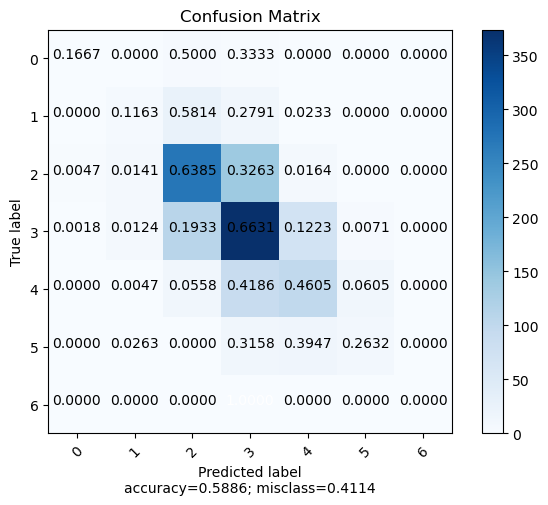

In [13]:
model = NnetMultiClass(int(x_train.shape[1]),int(np.unique(Y_train).shape[0]))
    
model.fit(x_train,Y_train,x_valid,Y_valid)

y_test_hat = model.predict(x_test)

test_accuracy = accuracy_score(Y_test,y_test_hat)
test_recall = recall_score(Y_test,y_test_hat,average='macro')
test_precision = precision_score(Y_test, y_test_hat,average='macro')
test_f1 = f1_score(Y_test,y_test_hat, average='macro')
print(f"Accuracy: {test_accuracy}")
print(f"Recall: {test_recall}")
print(f"Precision: {test_precision}")
print(f"F1-Score: {test_f1}")

conf_matrix = confusion_matrix(Y_test, y_test_hat)
plot_confusion_matrix(conf_matrix,target_names = np.unique(Y_test), \
                      title = "Confusion Matrix")

In [14]:
class CustomEmbDataset(Dataset):
    def __init__(self, X, emb, Y):
        self.X=X
        self.emb=emb
        self.Y=Y
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx,:], self.emb[idx],self.Y[idx]
  

class TestCustomEmbDataset(Dataset):
    def __init__(self, X, emb):
        self.X=X
        self.emb=emb
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx,:],self.emb[idx]


class NNetEmbLayers(torch.nn.Module):
    def __init__(self, inputs, outputs, n_vendor, n_embedding):
        super().__init__()
        self.embedding = torch.nn.Embedding(num_embeddings=n_vendor, embedding_dim=n_embedding)
        self.linear_1 = torch.nn.Linear(in_features=(inputs+n_embedding), out_features=200, bias = True)
        self.activation_1 = torch.nn.ReLU()
        self.dropout_1= torch.nn.Dropout(p=0.05)
        self.linear_2 = torch.nn.Linear(in_features=200, out_features=100, bias = True)
        self.activation_2 = torch.nn.ReLU()
        self.dropout_2= torch.nn.Dropout(p=0.05)
        self.linear_3 = torch.nn.Linear(in_features=100, out_features=outputs, bias = True)

    def forward(self, x, vendor_idx):
        vendor_emb = self.embedding(vendor_idx)
        final_input = torch.cat([x, vendor_emb], dim=1)
        # X es el batch que va a entrar
        z1 = self.linear_1(final_input)
        a1 = self.activation_1(z1)
        d1 = self.dropout_1(a1)
        z2 = self.linear_2(d1)
        a2 = self.activation_2(z2)
        d2 = self.dropout_2(a2)
        y = self.linear_3(d2)     
        return y
  
    
class NnetEmbMultiClass():
    
    def __init__(self, inputs, outputs, n_vendor, n_embeddings):
        self.nnet = NNetEmbLayers(inputs, outputs,n_vendor, n_embeddings)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        pass
    
        
    def fit(self,x_train, vendor_train, y_train, x_valid=None, vendor_valid=None, y_valid=None, \
            batch_size = 128, lr=0.001, epochs=1000, verbose=True):
        
        
        self.y_encoder = OneHotEncoder(sparse=True)
        self.y_encoder.fit(y_train.reshape(-1, 1))     
        
        self.x_encoder= MinMaxScaler()
        x_train=self.x_encoder.fit_transform(x_train)
        
        training_set = CustomEmbDataset(x_train, vendor_train, y_train)
        training_dataloader = DataLoader(training_set,batch_size=batch_size, \
                                         shuffle=True)
        
        if (x_valid is not None) & (y_valid is not None):
            x_valid = self.x_encoder.transform(x_valid)
            valid_set = CustomEmbDataset(x_valid, vendor_valid, y_valid)     
            valid_dataloader = DataLoader(valid_set,batch_size=len(valid_set), \
                                          shuffle= True)
        
        # Optimizer
        criterion = torch.nn.CrossEntropyLoss(reduction='sum')
        optimizer = torch.optim.Adam(self.nnet.parameters(),\
                                    lr=lr)
    
        # Training
        self.nnet.to(self.device)
        
        history_loss=[]
        history_train_auc=[]
        history_valid_auc=[]
        
        for epoch in range(epochs):
            running_loss = 0
            nnet_train_scores = []
            train_truth = []
            self.nnet.train()
            for i, data in enumerate(training_dataloader):
                x, vendor, y = data 
                x = x.to(self.device).float()
                vendor = vendor.to(self.device).long()
                #y = y.detach().numpy()
                #y = self.y_encoder.transform(y.reshape(-1, 1)).toarray()
                #y = torch.Tensor(y)
                y = y.to(self.device).long() 
    
                # set gradient to zero
                optimizer.zero_grad()
    
                # forward
                y_hat = self.nnet(x, vendor)
    
                # loss
                loss = criterion(y_hat, y)
    
                # backward
                loss.backward()
    
                # update of parameters
                optimizer.step()
    
                # compute loss and statistics
                running_loss += loss.item()
                
                y_hat = torch.softmax(y_hat,1)
                
                y_true = y.detach().numpy()
                y_true = self.y_encoder.transform(y_true.reshape(-1, 1)).toarray()
                train_truth += list(y_true) 
                nnet_train_scores += list(y_hat.detach().numpy())
                
            history_loss.append(running_loss/x_train.shape[0])
            
            train_auc = roc_auc_score(train_truth, nnet_train_scores,\
                                      multi_class='ovr')
            history_train_auc.append(train_auc)
    
            
            if (verbose) & ((epoch) % (epochs/10)==0):
                self.nnet.eval()
                with torch.no_grad():
                        
                    if (x_valid is not None) & (y_valid is not None):
                        
                        nnet_valid_scores = []
                        valid_truth = []
                    
                        for i, data in enumerate(valid_dataloader):
                            # batch
                            x, vendor, y = data 
                            x = x.to(self.device).float()
                            vendor = vendor.to(self.device).long()
                            #y = y.detach().numpy()
                            #y = self.y_encoder.transform(y.reshape(-1, 1)).toarray()
                            #y = torch.Tensor(y)
                            y = y.to(self.device).float()
                
                            # forward 
                            y_hat = self.nnet(x, vendor)
                
                            y_hat = torch.softmax(y_hat,1)
                
                            y_true = y.detach().numpy()
                            y_true = self.y_encoder.transform(y_true.reshape(-1, 1)).toarray()
                            valid_truth += list(y_true) 
                            nnet_valid_scores += list(y_hat.detach().numpy())
                               
                        valid_auc = roc_auc_score(valid_truth, nnet_valid_scores, multi_class='ovr')
                        history_valid_auc.append(valid_auc)
            
                        print(f"Epoch = {epoch} | " + \
                              f"loss = {running_loss / x_train.shape[0]} | " + \
                                  f"train auc: {train_auc}" + \
                                  f"valid auc: {valid_auc}")
                    else:
                        print(f"Epoch = {epoch} | " + \
                              f"loss = {running_loss / x_train.shape[0]} | " +\
                                   f"train auc: {train_auc}")
                            
        return history_loss,history_train_auc, history_valid_auc
        
    def predict(self,x, vendor):
        self.nnet.eval()
        with torch.no_grad():
            x = self.x_encoder.transform(x)
            test_set = TestCustomEmbDataset(x,vendor)
            test_dataloader = DataLoader(test_set,batch_size=len(test_set), \
                                         shuffle= False)
            
            for i, data in enumerate(test_dataloader):
                x,vendor = data 
                x = x.to(self.device).float() 
                vendor = vendor.to(self.device).long() 
                y_hat = self.nnet(x, vendor)
                y_hat = torch.softmax(y_hat,1)
                y_hat = y_hat.detach().numpy()
                y_hat = self.y_encoder.inverse_transform(y_hat)
        return y_hat[:,0]
    
    def predict_proba(self,x,vendor):
        self.nnet.eval()
        with torch.no_grad():
            x = self.x_encoder.transform(x)
            test_set = TestCustomEmbDataset(x,vendor)
            test_dataloader = DataLoader(test_set,batch_size=len(test_set), \
                                         shuffle= False)
            
            for i, data in enumerate(test_dataloader):
                x,vendor = data 
                x = x.to(self.device).float() 
                vendor = x.to(self.device).long() 
                y_hat = self.nnet(x,vendor)
                y_hat = torch.softmax(y_hat,1)
                y_hat = y_hat.detach().numpy()

        return y_hat

Epoch = 0 | loss = 1.4733722666476636 | train auc: 0.5320685371912439valid auc: 0.6572952257055308
Epoch = 30 | loss = 0.01836959642990415 | train auc: 0.9999192965049909valid auc: 0.9339337774518058
Epoch = 60 | loss = 0.001977369598179652 | train auc: 1.0valid auc: 0.9367737671583246
Epoch = 90 | loss = 0.0006323336579474824 | train auc: 1.0valid auc: 0.9389346265590175
Epoch = 120 | loss = 0.0002639701496944826 | train auc: 1.0valid auc: 0.9371889061888833
Epoch = 150 | loss = 0.001418174918946122 | train auc: 0.9999973476393084valid auc: 0.9348942086722801
Epoch = 180 | loss = 5.659234685486629e-05 | train auc: 1.0valid auc: 0.9397575833532036
Epoch = 210 | loss = 0.0007387246214368108 | train auc: 1.0valid auc: 0.9387876563959257
Epoch = 240 | loss = 8.577312546267896e-05 | train auc: 1.0valid auc: 0.9447045287542978
Epoch = 270 | loss = 2.800041570824011e-05 | train auc: 1.0valid auc: 0.9444175246179765


C:\Users\MaxiT\.conda\envs\MAXI\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9814385150812065
Recall: 0.6525616366497639
Precision: 0.6799322837109789
F1-Score: 0.6635497217595969


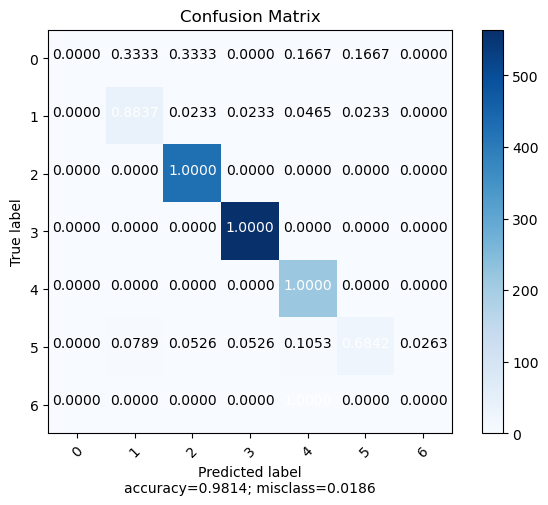

In [15]:
model = NnetEmbMultiClass(x_train.shape[1],np.unique(Y_train).shape[0], len(index_to_vendor),16)
    
model.fit(x_train, vendor_train, Y_train, x_valid, vendor_valid, Y_valid, epochs=300)

y_test_hat = model.predict(x_test,vendor_test)

test_accuracy = accuracy_score(Y_test,y_test_hat)
test_recall = recall_score(Y_test,y_test_hat,average='macro')
test_precision = precision_score(Y_test, y_test_hat,average='macro')
test_f1 = f1_score(Y_test,y_test_hat, average='macro')
print(f"Accuracy: {test_accuracy}")
print(f"Recall: {test_recall}")
print(f"Precision: {test_precision}")
print(f"F1-Score: {test_f1}")

conf_matrix = confusion_matrix(Y_test, y_test_hat)
plot_confusion_matrix(conf_matrix,target_names = np.unique(Y_test), \
                      title = "Confusion Matrix")